## (A) Neural Matrix Factorizarion Steps -  NeuMF Paper

1.   Usually given a "user-item" observation matrix M with explicit feedback data.

---

2.   Two learning approaches can be adopted:

*   Pointwise learning: follows a regression framework by minimizing the squred loss between *yPredicted* and *yObserved*.
*   Pairwise learning: this ranks observed entries higher relative to unobserved entries, and maximizes the margin between them.

---

3. Electing pointwise learning, the training phase involves searching for the optimal parameters that minimizes this squared loss over a reduced (k-dimensional) feature space.

---

*   Predictions can then be made for the unobserved entries.
*   In essence, both the observed and unobserved entries have been approximated by a non-linear function, which presumably improves upon linear(dot product) approximation.

---

To cluster based on the output matrix, we can compute gene scores

---

What's often done(and adopted by the paper) is to restructure the problem to make use of implit data (more easy to collect compared to explicit data)

So in this case, the observation matrix M is converted into a binary interaction matrix P. The training prediction processes are similar as in the case of learning with M.

---
---


## (B) Recovering the gene expression matrix(normalized) from LIGER ##

1. Pass the downsampled control and interferon-stimulated PBMCs to the LIGER function.

2. The LIGER function returns a normalized **H1, H2**, **V1, V2**, and **W**(shared) by performing non-negative matrix factorization.

3. These matrices can be used to recover a dense representation of the original expression matrices.

4. ** The "cell paper" then achieves integrative clustering by buildng a shared neighbourhood graph following the five steps of "Joint clustering and factor normalization" under the STAR methods.

---
---


## (C) Self Implementation - Presumably Wrong (not feasible)

### Get data:
1. A first option to getting the gene expression matrices is to recover them from the LIGER output.



*   The recovered matrices are a dense representation of the original expressiom matrices

2. A second option will be to get the raw representation, ignoring the built-in advantage of shared factor loading present in 1.

---
**Why none of these two options can produce matrices suitable for training the network:**

1. They do not contain negative instances (unobserved/missing entries)























In [ ]:
# load packages
import math
import time
import umap
import heapq
!pip install hdbscan
import hdbscan
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
from tqdm import tqdm
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
from sklearn.utils import shuffle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
# load data
H = pd.read_csv("H.csv") # 3000 x 40
ctr_rownames = pd.read_csv("ctrl_rownames.csv")
# separate into the two groups
ctr_H = H.iloc[:, 0:20] # 3000 x 20
stm_H = H.iloc[:, 10:40] # 3000 x 20

V = pd.read_csv("V.csv") # 20 x 2(2430)
ctr_V = V.iloc[:, 0:2430] # 20 x2430
stm_V = V.iloc[:, 2430:4860] # 20 x 2430

W = pd.read_csv("W.csv") # 20 x 2430

full_data = pd.read_csv("scaledata.csv")
full_data1 = full_data.iloc[:, 0:2430]
full_data2 = full_data.iloc[:, 2430:4860]

In [ ]:
# check dimensions and get brief view
ctr_H.head()

,ctrl.1,ctrl.2,ctrl.3,ctrl.4,ctrl.5,ctrl.6,ctrl.7,ctrl.8,ctrl.9,ctrl.10,ctrl.11,ctrl.12,ctrl.13,ctrl.14,ctrl.15,ctrl.16,ctrl.17,ctrl.18,ctrl.19,ctrl.20
0,0.003480,0.000723,0.0,0.001838,0.006700,0.000000,0.000781,0.001204,0.000000,0.000161,0.004740,0.001837,0.000000,0.009754,0.002384,0.001563,0.003565,0.0,0.001454,0.000151
1,0.000000,0.000253,0.0,0.000000,0.000670,0.000000,0.000190,0.000219,0.000000,0.000000,0.000000,0.000000,0.000447,0.018527,0.000000,0.004113,0.016116,0.0,0.000000,0.000000
2,0.002317,0.000032,0.0,0.000761,0.000000,0.000000,0.005570,0.002722,0.000457,0.010896,0.000000,0.000000,0.000000,0.000403,0.011842,0.000000,0.000000,0.0,0.000000,0.004438
3,0.001932,0.005964,0.0,0.000182,0.000646,0.000000,0.000000,0.000018,0.003920,0.001864,0.000000,0.000000,0.002554,0.026437,0.000206,0.001520,0.000000,0.0,0.000015,0.001713
4,0.007209,0.002954,0.0,0.000000,0.000000,0.001156,0.000000,0.000529,0.002762,0.000000,0.006244,0.000367,0.000105,0.000000,0.004140,0.001773,0.000000,0.0,0.019436,0.000000


In [ ]:
print("Shape of V: ", V.shape, " | Shape of W: ", W.shape, " | Shape of H: ", H.shape)

Shape of V:  (20, 4860)  | Shape of W:  (20, 2430)  | Shape of H:  (3000, 40)


In [ ]:
# try implementation for the first half
ctr_H_matrix = ctr_H.to_numpy()
ctr_V_matrix = ctr_V.to_numpy()
W_matrix = W.to_numpy()
# add w and v
ctr_G_merged_matrix = ctr_V_matrix + W_matrix
ctr_E_matrix = np.matmul(ctr_H_matrix, ctr_G_merged_matrix)
# convert to dataframe
ctr_E_df = pd.DataFrame(ctr_E_matrix)
ctr_E_df['cell'] = ctr_rownames.iloc[0:, ].values
# truncate to observe results
ctr_E_df = ctr_E_df.iloc[0:200, 2190:2431]
# convert to long format
ctr_E_df_long = pd.melt(ctr_E_df, id_vars=['cell'],var_name='gene', value_name='expression')

In [ ]:
ctr_E_df.head()

,2190,2191,2192,2193,2194,2195,2196,2197,2198,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427,2428,2429,cell
0,0.042660,0.169971,0.135982,0.199864,0.346668,0.157072,0.045996,0.152671,0.231004,0.217516,0.088903,0.388157,0.390078,0.213129,0.036089,0.164132,0.138309,0.327182,0.048008,0.105497,0.219932,0.110102,0.162827,0.418150,0.088941,0.056629,0.607646,0.136955,0.059568,0.148554,0.224272,0.224232,0.329457,0.207896,0.244046,0.045494,0.049834,0.048129,0.405315,0.092950,...,0.199391,0.031759,0.041994,0.122269,0.497023,0.187801,0.354461,0.267013,0.028597,0.241574,0.055377,0.078044,0.240502,0.548219,0.061631,0.134478,0.103410,0.246193,0.137390,0.365251,0.062662,0.000000,0.126247,0.312233,0.115086,0.246584,0.199582,0.265216,0.075692,0.103097,0.484061,0.068967,0.133271,0.515252,0.137651,0.287084,0.140056,0.435782,0.182625,ctrlTCAGCGCTGGTCAT-1
1,0.023440,0.086373,0.025073,0.148593,0.166523,0.104957,0.048568,0.164804,0.143925,0.139834,0.034616,0.514158,0.345524,0.150766,0.013685,0.051982,0.105822,0.193454,0.000000,0.038705,0.134491,0.126896,0.083318,0.292490,0.074860,0.006948,0.600390,0.008562,0.000893,0.035369,0.013165,0.164099,0.173584,0.170175,0.221613,0.002100,0.013751,0.004894,0.725878,0.174706,...,0.294390,0.014348,0.042287,0.080733,0.384121,0.241507,1.151996,0.213177,0.031061,0.415011,0.031041,0.013986,0.066320,1.529111,0.000000,0.028452,0.134431,0.290833,0.090297,0.493497,0.003307,0.000000,0.090551,0.525650,0.029812,0.277160,0.144593,0.158962,0.140869,0.004332,0.675492,0.086836,0.165928,0.768137,0.092153,0.070293,0.059213,0.516008,0.091449,ctrlTTATGGCTTCATTC-1
2,0.115133,0.413478,0.241859,0.241126,0.449797,0.285886,0.060786,0.153544,0.211793,0.432053,0.194006,0.097884,0.245159,0.203801,0.093761,0.177896,0.296450,0.437977,0.031680,0.004538,0.121905,0.015123,0.146565,0.322635,0.066811,0.112843,0.772821,0.099976,0.013067,0.112244,0.468964,0.230032,0.462020,0.363697,0.271181,0.181697,0.109515,0.175454,0.036497,0.098393,...,0.229558,0.056386,0.060170,0.100735,0.709580,0.113550,0.031170,0.338667,0.085562,0.016718,0.062632,0.129205,0.180016,0.018203,0.025517,0.060683,0.096632,0.111214,0.218396,0.206181,0.188776,0.000000,0.163848,0.127725,0.349757,0.180379,0.303603,0.473391,0.011669,0.149023,0.526911,0.099938,0.234559,0.047623,0.130729,0.235993,0.123458,0.359991,0.073637,ctrlACCCACTGCTTAGG-1
3,0.034034,0.142593,0.036596,0.171669,0.287472,0.156911,0.046605,0.226232,0.211482,0.220086,0.052673,0.273564,0.486725,0.108202,0.011282,0.068332,0.052081,0.306096,0.035593,0.867312,0.168932,0.161455,0.119028,0.366574,0.122579,0.014626,0.609982,0.083091,0.006112,0.038120,0.041677,0.162364,0.233711,0.182937,0.269435,0.050996,0.000707,0.009918,0.883395,0.161898,...,0.293677,0.004310,0.060505,0.055362,0.479892,0.144947,0.497312,0.295605,0.007933,0.617482,0.058234,0.034356,0.121859,0.970660,0.006103,0.050602,0.203086,0.292389,0.074542,0.511806,0.022727,0.000000,0.128549,0.129387,0.029820,0.341477,0.189556,0.193206,0.064006,0.038108,0.500423,0.090596,0.153141,0.927183,0.063902,0.150418,0.070966,0.474641,0.095232,ctrlATGGGTACCCCGTT-1
4,0.082656,0.243032,0.187444,0.152001,0.384992,0.167269,0.025938,0.189467,0.448042,0.188769,0.212729,0.418670,0.236966,0.348366,0.165916,0.372853,0.295516,0.481103,0.101747,0.423559,0.244424,0.192214,0.158200,0.532347,0.027177,0.239663,0.444700,0.199567,0.252094,0.128323,0.085195,0.325989,0.584070,0.289250,0.393572,0.090642,0.028291,0.054913,0.221780,0.036827,...,0.214635,0.133757,0.130102,0.249739,1.130847,0.430238,0.220534,0.421614,0.008451,0.026486,0.117866,0.137989,0.334509,0.040191,0.000000,0.282375,0.070685,0.293539,0.186052,0.118777,0.048921,0.187227,0.179938,0.155865,0.081449,0.190389,0.192174,0.481580,0.136434,0.320792,0.25680

In [ ]:
(ctr_E_df_long == 0).astype(int).sum(axis=0)

cell            0
gene            0
expression    383
dtype: int64

In [ ]:
print("Unique genes: ", len((ctr_E_df_long['gene'].astype("category").cat.codes).drop_duplicates()))#.sort_values()
print("Unique cells: ",len((ctr_E_df_long['cell'].astype("category").cat.codes).drop_duplicates()))

Unique genes:  240
Unique cells:  200


Build Helper Functions

In [ ]:
# process data set
def process_dataset(df):

    #df = df.dropna()
    #df = df.loc[df.expression != 0]

    # Convert cells names into numerical IDs
    df['cell_id'] = df['cell'].astype("category").cat.codes
    df['gene_id'] = df['gene'].astype("category").cat.codes


    gene_lookup = df[['gene_id', 'gene']].drop_duplicates()
    gene_lookup['gene_id'] = gene_lookup.gene_id.astype(str)

    # Grab the columns we need in the order we need them.
    df = df[['cell_id', 'gene_id', 'expression']]


    df_train, df_test = train_test_split(df) # 80 20


    cells = list(np.sort(df.cell_id.unique()))
    genes = list(np.sort(df.gene_id.unique()))


    rows = df_train.cell_id.astype(int)
    cols = df_train.gene_id.astype(int)

    values = list(df_train.expression)

    # Get all usercell ids and gene ids.
    cids = np.array(rows.tolist())
    gids = np.array(cols.tolist())

    # Sample 100 negative interactions for each cell in our test data
    df_neg = get_negatives(cids, gids, genes, df_test)

    return cids, gids, df_train, df_test, df_neg, cells, genes, gene_lookup

In [ ]:
# sample a couple of negatives for each positive label
def get_negatives(cids, gids, genes, df_test):

    negativeList = []
    test_c = df_test['cell_id'].values.tolist()
    test_g = df_test['gene_id'].values.tolist()

    test_expression_ids = list(zip(test_c, test_g))
    zipped = set(zip(cids, gids))

    for (c, g) in test_expression_ids:
        negatives = []
        negatives.append((c, g))
        for t in range(10):# increase for better accuracy
            j = np.random.randint(len(genes)) # Get random gene id.
            while (c, j) in zipped: # Check if there is an interaction
                j = np.random.randint(len(genes)) # If yes, generate a new gene id
            negatives.append(j) # Once a negative interaction is found we add it.
        negativeList.append(negatives)

    df_neg = pd.DataFrame(negativeList)

    return df_neg

In [ ]:
# mask the first gene to be used for testing
def mask_first(x):
    result = np.ones_like(x)
    result[0] = 0

    return result

# split into train and test set
def train_test_split(df):

    df_test = df.copy(deep=True)
    df_train = df.copy(deep=True)

    df_test = df_test.groupby(['cell_id']).first()
    df_test['cell_id'] = df_test.index
    df_test = df_test[['cell_id', 'gene_id', 'expression']]
    df_test.index.name = None

    mask = df.groupby(['cell_id'])['cell_id'].transform(mask_first).astype(bool)
    df_train = df.loc[mask]

    return df_train, df_test

# combine mask and train test split
def get_train_instances():

    cell_input, gene_input, labels = [],[],[]
    zipped = set(zip(cids, gids))
    #progress = tqdm(total=len(zipped))
    #tracker = 0
    for (c, g) in zip(cids, gids):
        # Add our positive interaction
        cell_input.append(c)
        gene_input.append(g)
        #labels.append((df_train[(df_train.cell_id==c)&(df_train.gene_id==g)]).expression.values[0])
        labels.append(1)
        #print("gene value: ", g, " cell value: ", c)

        # Sample a number of random negative interactions
        for t in range(num_neg):
            j = np.random.randint(len(genes))
            while (c, j) in zipped:
                j = np.random.randint(len(genes))
                #j = rv+1 if rv==0 else rv
            cell_input.append(c)
            gene_input.append(j)
            #print("gene value: ", j, " cell value: ", c)
            labels.append(0)
            #labels.append((df_train[(df_train.cell_id==c)&(df_train.gene_id==j)]).expression.values[0])
        #progress.update(1)
        #progress.set_description('Sampled Training Instance' + str(tracker+1))
        #tracker+=1
    #progress.close()
    return cell_input, gene_input, labels

# for faster training
def random_mini_batches(C, G, L, mini_batch_size=20):

    mini_batches = []

    shuffled_C, shuffled_G, shuffled_L = shuffle(C, G, L, random_state=0)

    num_complete_batches = int(math.floor(len(C)/mini_batch_size))
    for k in range(0, num_complete_batches):
        mini_batch_C = shuffled_C[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_G = shuffled_G[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_L = shuffled_L[k * mini_batch_size : k * mini_batch_size + mini_batch_size]

        mini_batch = (mini_batch_C, mini_batch_G, mini_batch_L)
        mini_batches.append(mini_batch)

    if len(C) % mini_batch_size != 0:
        mini_batch_C = shuffled_C[num_complete_batches * mini_batch_size: len(C)]
        mini_batch_G = shuffled_G[num_complete_batches * mini_batch_size: len(C)]
        mini_batch_L = shuffled_L[num_complete_batches * mini_batch_size: len(C)]

        mini_batch = (mini_batch_C, mini_batch_G, mini_batch_L)
        mini_batches.append(mini_batch)

    return mini_batches

In [ ]:
# evaluation
def get_hits(k_ranked, holdout):
    for gene in k_ranked:
        if gene == holdout:
            return 1
    return 0

def eval_rating(idx, test_expression, test_negatives, K):
    # test_expression = test_expression_ids
    map_gene_score = {}


    genes = test_negatives[idx]


    cell_idx = test_expression[idx][0]


    holdout = test_expression[idx][1]
    print("Holdout: ", holdout)


    genes.append(holdout)


    predict_cell = np.full(len(genes), cell_idx, dtype='int32').reshape(-1,1)
    print("Predict cell: ", predict_cell)
    np_genes = np.array(genes).reshape(-1,1)
    print("Genes: ", genes)


    predictions = session.run([output_layer], feed_dict={cell: predict_cell, gene: np_genes})
    print("Predictions: ", predictions)

    predictions = predictions[0].flatten().tolist()


    for i in range(len(genes)):
        current_gene = genes[i]
        map_gene_score[current_gene] = predictions[i]


    k_ranked = heapq.nlargest(K, map_gene_score, key=map_gene_score.get)
    print("K Ranked: ", k_ranked)


    hits = get_hits(k_ranked, holdout)

    return hits

#
def evaluate(df_neg, K=10):

    hits = []

    test_c = df_test['cell_id'].values.tolist()
    test_g = df_test['gene_id'].values.tolist()

    test_expression_ids = list(zip(test_c, test_g))

    df_neg = df_neg.drop(df_neg.columns[0], axis=1)
    test_negatives = df_neg.values.tolist()
    #len(test_expression)-2
    for idx in range(len(test_expression_ids)):
        # For each idx, call eval_one_rating
        hitrate = eval_rating(idx, test_expression_ids, test_negatives, K)
        hits.append(hitrate)

    return hits

In [ ]:
def make_recommendation(cell_ids=None, gene_ids = None, top=None):
    # make recommendations for all
    df = pd.DataFrame()
    df["Gene"] = (ctr_E_df_long.gene_id).unique()
    for cell_idx in np.sort((ctr_E_df_long.cell_id).unique()):
        # get the genes for the given cell
        genes = ((ctr_E_df_long[ctr_E_df_long.cell_id==cell_idx]).gene_id).values
        cell_ls = [cell_idx]# * len(genes)
        # create a full gene prediction for a cell
        predict_cell = np.full(len(genes), cell_idx, dtype='int32').reshape(-1,1)
        np_genes = np.array(genes).reshape(-1,1)

        #run with the given session
        predictions = session.run([output_layer], feed_dict={cell: predict_cell, gene: np_genes})
        #print("Predictions: ", predictions)

        predictions = predictions[0].flatten().tolist()
        df[cell_idx] = predictions

    return df

# try basic k-means clustering
def kMeans_clustering(k=10):
  kmeans_labels = cluster.KMeans(n_clusters=k).fit_predict(mlp_df)
  standard_embedding = umap.UMAP(random_state=42).fit_transform(mlp_df)
  newdf = pd.DataFrame(standard_embedding, columns = ["x1", "x2"])
  newdf["cluster"] = kmeans_labels
  # make the plot
  size = 80
  plt.figure(figsize=(16,10))
  sc = plt.scatter(newdf['x1'], newdf['x2'], s=size, c=newdf['cluster'], edgecolors='none')

  lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                          label="Cluster {:g}".format(i), ls="", marker="o")[0]
  handles = [lp(i) for i in np.unique(newdf["cluster"])]
  plt.legend(handles=handles)
  plt.xlabel("Umap 1")
  plt.ylabel("Umap 2")
  plt.show()

In [ ]:
cids, gids, df_train, df_test, df_neg, cells, genes, gene_lookup = process_dataset(ctr_E_df_long)

In [ ]:
print("Unique train genes: ", len((df_train['gene_id']).drop_duplicates()))
print("Unique train cells: ", len((df_train['cell_id']).drop_duplicates()))
print("Unique test genes: ", len((df_test['gene_id']).drop_duplicates()))
print("Unique test cells: ",len((df_test['cell_id']).drop_duplicates()))

Unique train genes:  239
Unique train cells:  200
Unique test genes:  1
Unique test cells:  200


In [ ]:
df_neg.head()

,0,1,2,3,4,5,6,7,8,9,10
0,"(0, 0)",0,0,0,0,0,0,0,0,0,0
1,"(1, 0)",0,0,0,0,0,0,0,0,0,0
2,"(2, 0)",0,0,0,0,0,0,0,0,0,0
3,"(3, 0)",0,0,0,0,0,0,0,0,0,0
4,"(4, 0)",0,0,0,0,0,0,0,0,0,0


In [ ]:
# define learning parameters
num_neg = 4
epochs = 20
batch_size = 20
learning_rate = 0.001

In [ ]:
# get train instances
cell_input, gene_input, labels = get_train_instances()

Build MLP Network

In [ ]:
graph = tf.Graph() # tensorflow term for building a pipeline

with graph.as_default():

    # define input placeholders for cell, gene and count=label.
    cell = tf.placeholder(tf.int32, shape=(None, 1))
    gene = tf.placeholder(tf.int32, shape=(None, 1))
    label = tf.placeholder(tf.int32, shape=(None, 1))

    # cell feature embedding
    c_var = tf.Variable(tf.random_normal([len(cells), 20], stddev=0.05), name='cell_embedding')
    cell_embedding = tf.nn.embedding_lookup(c_var, cell) # for each cell id, return a vector of length 20

    # gene feature embedding
    g_var = tf.Variable(tf.random_normal([len(genes), 20], stddev=0.05), name='gene_embedding')
    gene_embedding = tf.nn.embedding_lookup(g_var, gene) # for each gene id, return a vector of length 20

    # Flatten our cell and gene embeddings.
    cell_embedding = tf.keras.layers.Flatten()(cell_embedding)
    gene_embedding = tf.keras.layers.Flatten()(gene_embedding)

    # concatenate the two embedding vectors
    concatenated = tf.keras.layers.concatenate([cell_embedding, gene_embedding])


    # add a first dropout layer.
    dropout = tf.keras.layers.Dropout(0.2)(concatenated)

    # add four hidden layers along with batch
    # normalization and dropouts. use relu as the activation function.
    layer_1 = tf.keras.layers.Dense(64, activation='relu', name='layer1')(dropout)
    batch_norm1 = tf.keras.layers.BatchNormalization(name='batch_norm1')(layer_1)
    dropout1 = tf.keras.layers.Dropout(0.2, name='dropout1')(batch_norm1)

    layer_2 = tf.keras.layers.Dense(32, activation='relu', name='layer2')(layer_1)
    batch_norm2 = tf.keras.layers.BatchNormalization(name='batch_norm1')(layer_2)
    dropout2 = tf.keras.layers.Dropout(0.2, name='dropout1')(batch_norm2)

    layer_3 = tf.keras.layers.Dense(16, activation='relu', name='layer3')(layer_2)
    layer_4 = tf.keras.layers.Dense(8, activation='relu', name='layer4')(layer_3)

    # final single neuron output layer.
    output_layer = tf.keras.layers.Dense(1,
            kernel_initializer="lecun_uniform",
            name='output_layer')(layer_4)

    # our loss function as binary cross entropy.
    labels = tf.cast(label, tf.float32)
    logits = output_layer
    tf.print(logits)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=labels,
                logits=logits))

    # train using the Adam optimizer to minimize loss.
    opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
    step = opt.minimize(loss)

    # initialize all tensorflow variables.
    init = tf.global_variables_initializer()

session = tf.Session(config=None, graph=graph)
session.run(init)

In [ ]:
for epoch in range(epochs):

    # Get our training input.
    cell_input, gene_input, labels = get_train_instances()

    # Generate a list of minibatches.
    minibatches = random_mini_batches(cell_input, gene_input, labels)

    # This has noting to do with tensorflow but gives
    # us a nice progress bar for the training
    progress = tqdm(total=len(minibatches))

    # Loop over each batch and feed our cells, genes and labels
    # into our graph.
    for minibatch in minibatches:
        feed_dict = {cell: np.array(minibatch[0]).reshape(-1,1),
                    gene: np.array(minibatch[1]).reshape(-1,1),
                    label: np.array(minibatch[2]).reshape(-1,1)}

        # Execute the graph.
        _, l = session.run([step, loss], feed_dict)

        # Update the progress
        progress.update(1)
        progress.set_description('Epoch: %d - Loss: %.8f' % (epoch+1, l))

    progress.close()


# Calculate top@K
hits = evaluate(df_neg)
print(np.array(hits).mean())

Epoch: 20 - Loss: 0.00000000: 100%|██████████| 11950/11950 [00:38<00:00, 309.96it/s]


Streaming output truncated to the last 5000 lines.
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Genes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions:  [array([[-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944],
       [-31.899944]], dtype=float32)]
K Ranked:  [0]
Holdout:  0
Predict cell:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Genes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions:  [array([[-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992],
       [-31.726992]], dtype=float32)]
K Ranked:  [0]
Holdout:  0
Predict cell:  [[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]
Genes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions:  [array([[-31.008947],
       [-31.00

In [ ]:
mlp_df = make_recommendation()
mlp_df.head()

,Gene,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,-31.899944,-31.726992,-31.008947,-31.222002,-31.074297,-30.787359,-31.604448,-32.313484,-31.852266,-31.083963,-31.870346,-31.868269,-31.907572,-32.268124,-31.783884,-32.084660,-31.519373,-32.029106,-31.056795,-30.917875,-31.134233,-30.995008,-30.747757,-32.417625,-32.074352,-31.512430,-31.740282,-31.867590,-31.671476,-31.547699,-31.072832,-32.026409,-31.885389,-31.491598,-32.605671,-31.952639,-31.624153,-31.322947,-32.143337,...,-32.110149,-32.747501,-32.173592,-32.072990,-31.541677,-31.973536,-31.351557,-31.936857,-32.015289,-31.931229,-32.299305,-31.124281,-31.640749,-31.789083,-31.094004,-31.734091,-31.077089,-31.343801,-32.201668,-31.868399,-31.851553,-31.253664,-32.349152,-30.969410,-30.817333,-31.095526,-31.062799,-31.755373,-32.098721,-31.279997,-31.054995,-31.264469,-32.338417,-31.509991,-31.354698,-31.432940,-31.659504,-31.104822,-31.367048,-31.613577
1,1,20.404377,19.095434,18.238018,18.661337,18.057076,18.781075,19.912472,19.453493,20.263973,18.260069,18.586521,19.183483,19.725882,19.715103,18.999422,19.618299,18.427896,19.923933,18.358576,18.117865,19.037443,19.033747,18.714979,19.607611,19.501799,19.004622,18.230213,19.538450,18.175652,18.020437,19.658211,19.036541,19.383303,18.179256,20.682510,19.942753,18.464231,18.083035,19.468287,...,19.241318,19.932724,18.011772,19.467102,19.645628,18.890768,18.683035,20.850039,19.677402,18.294245,19.401857,18.305439,18.163387,19.526731,18.294947,19.515945,19.702097,19.429861,19.698381,18.934599,18.677444,18.856220,19.860376,18.751062,18.297432,19.875372,18.665121,19.060509,18.758127,20.307230,18.565308,19.634722,21.027536,18.343988,19.372835,19.855038,18.943115,18.530447,19.142998,19.555006
2,2,21.379671,19.901985,19.185423,19.489056,18.979208,19.473957,20.693043,20.625948,20.940001,19.122002,19.614571,20.250500,20.486204,20.746468,20.032705,20.839258,19.354462,20.864153,19.242579,19.000132,19.821142,19.845480,19.295345,20.753687,20.563164,19.873640,19.488066,20.539442,19.211390,19.160299,20.169634,20.162245,20.237467,19.185213,21.764013,21.047956,19.599840,19.091743,20.662745,...,20.348347,21.160784,19.308182,20.522306,20.450651,20.052824,19.545956,21.713820,20.666180,19.417629,20.390295,19.222811,19.165588,20.405428,19.191919,20.413082,20.250235,20.167345,20.757154,19.824532,19.859076,19.660582,21.097271,19.394400,19.059181,20.358702,19.459284,20.076513,19.939716,20.821848,19.385675,20.271172,21.873825,19.366396,20.078791,20.712797,19.968292,19.501728,19.973667,20.355169
3,3,23.506330,22.451418,21.200655,21.645746,21.299978,21.296873,22.909145,23.557978,23.353825,21.177473,22.313189,22.647505,23.193178,23.702177,22.652582,23.240961,21.999594,23.370321,21.207869,21.114912,21.860125,21.746538,21.059547,23.630293,23.219973,22.061720,22.145115,23.125963,21.912516,21.672329,22.229418,22.901978,22.769398,21.669485,24.696768,23.496521,21.996622,21.425699,23.216091,...,23.075851,24.206520,22.351004,23.137743,22.611906,22.712076,21.808777,23.797974,23.169188,22.278721,23.378687,21.333002,21.745993,22.798695,21.362749,22.607592,22.304531,22.429991,23.534346,22.482332,22.306612,21.972099,23.869719,21.380833,21.208878,22.306650,21.574476,22.591440,22.758389,22.727489,21.512762,22.380175,24.449713,21.918943,22.337774,22.636229,22.333187,21.528978,22.280420,22.649794
4,4,20.776442,19.449970,18.528166,19.126562,18.680937,19.044268,20.139990,20.036991,20.412996,18.594555,19.096964,19.673370,20.177546,20.202711,19.507702,20.058943,18.980146,20.291882,18.615004,18.667398,19.512747,19.273836,18.737251,20.060686,19.970057,19.437454,18.846754,20.009279,18.521360,18.702869,19.758171,19.590843,19.860582,18.578743,21.373411,20.466265,19.262987,18.439960,19.973383,...,19.948912,20.635025,18.707853,20.013180,19.926100,19.4

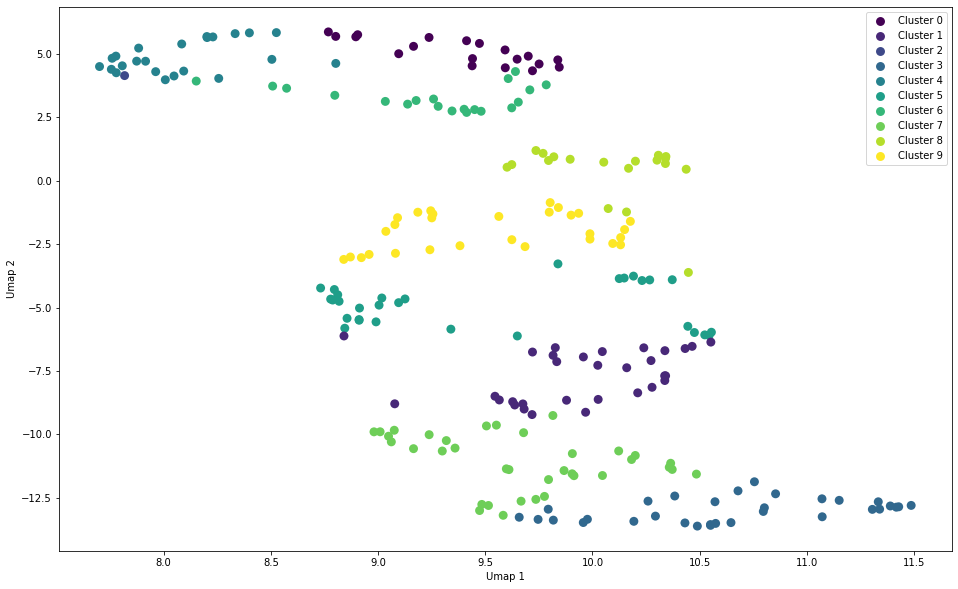

In [ ]:
# try basic clustering
kMeans_clustering()

Build GMF Network

In [ ]:
graph = tf.Graph()
latent_features = 20

with graph.as_default():

    cell = tf.placeholder(tf.int32, shape=(None, 1))
    gene = tf.placeholder(tf.int32, shape=(None, 1))
    label = tf.placeholder(tf.int32, shape=(None, 1))


    c_var = tf.Variable(tf.random_normal([len(cells), latent_features],
                                         stddev=0.05), name='cell_embedding')
    cell_embedding = tf.nn.embedding_lookup(c_var, cell)


    g_var = tf.Variable(tf.random_normal([len(genes), latent_features],
                                         stddev=0.05), name='gene_embedding')
    gene_embedding = tf.nn.embedding_lookup(g_var, gene)

    # flatten the embeddings
    cell_embedding = tf.keras.layers.Flatten()(cell_embedding)
    gene_embedding = tf.keras.layers.Flatten()(gene_embedding)

    # multiplying our cell and gene latent space vectors together
    prediction_matrix = tf.multiply(cell_embedding, gene_embedding)


    output_layer = tf.keras.layers.Dense(1,
            kernel_initializer="lecun_uniform",
            name='output_layer')(prediction_matrix)

    # loss function as a binary cross entropy.
    loss = tf.losses.sigmoid_cross_entropy(label, output_layer)

    # using the Adam optimizer to minimize loss.
    opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
    step = opt.minimize(loss)

    # initialize all tensorflow variables.
    init = tf.global_variables_initializer()

session = tf.Session(config=None, graph=graph)
session.run(init)

In [ ]:
for epoch in range(epochs):

    # Get our training input.
    cell_input, gene_input, labels = get_train_instances()

    # Generate a list of minibatches.
    minibatches = random_mini_batches(cell_input, gene_input, labels)

    # This has noting to do with tensorflow but gives
    # us a nice progress bar for the training
    progress = tqdm(total=len(minibatches))

    # Loop over each batch and feed our cells, genes and labels
    # into our graph.
    for minibatch in minibatches:
        feed_dict = {cell: np.array(minibatch[0]).reshape(-1,1),
                    gene: np.array(minibatch[1]).reshape(-1,1),
                    label: np.array(minibatch[2]).reshape(-1,1)}

        # Execute the graph.
        _, l = session.run([step, loss], feed_dict)

        # Update the progress
        progress.update(1)
        progress.set_description('Epoch: %d - Loss: %.3f' % (epoch+1, l))

    progress.close()

Epoch: 20 - Loss: 0.000: 100%|██████████| 11950/11950 [00:30<00:00, 394.60it/s]


In [ ]:
mlp_df = make_recommendation()
mlp_df.head()

,Gene,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,-30.777044,-30.758657,-30.869555,-31.119963,-31.044241,-31.093828,-30.838408,-30.876270,-30.734732,-30.843931,-30.776728,-30.983809,-30.901669,-30.764685,-31.027582,-30.772745,-30.900843,-30.724831,-30.685747,-30.911808,-30.702076,-30.770620,-31.122721,-30.772278,-30.903120,-30.808432,-30.897585,-30.785131,-30.797832,-31.009504,-30.842161,-30.924456,-30.861479,-31.065491,-30.828539,-30.817240,-30.991465,-30.861353,-30.773279,...,-30.895134,-30.667440,-30.702879,-31.064047,-30.792864,-30.986872,-30.762255,-30.887903,-30.986727,-30.788454,-30.777836,-30.880745,-30.860693,-30.804800,-30.727222,-30.835428,-30.826300,-30.747570,-30.914770,-31.001434,-30.746054,-31.021305,-30.744961,-30.784773,-30.740011,-30.942923,-30.742502,-30.856016,-30.804079,-30.801012,-30.760946,-30.650761,-30.758448,-30.781153,-31.010143,-30.660379,-30.663214,-30.651342,-30.843073,-30.663515
1,1,17.224110,17.230968,17.255569,17.411770,17.348354,17.409313,17.315126,17.289328,17.200583,17.238382,17.216417,17.355787,17.294937,17.279716,17.393919,17.215900,17.318304,17.176819,17.178053,17.323019,17.181540,17.310909,17.463774,17.178989,17.274853,17.328159,17.238512,17.266350,17.284454,17.299894,17.296129,17.312759,17.308416,17.431175,17.212931,17.213751,17.366102,17.250105,17.267797,...,17.336319,17.155540,17.183975,17.354197,17.255526,17.319818,17.257427,17.374773,17.323730,17.263741,17.307013,17.258085,17.328375,17.295435,17.227699,17.244215,17.295551,17.224539,17.321312,17.338503,17.233454,17.345373,17.312977,17.296549,17.203669,17.355997,17.177969,17.254955,17.291468,17.223299,17.254320,17.232159,17.258234,17.244301,17.379381,17.239779,17.179892,17.244440,17.246374,17.196115
2,2,17.259809,17.325796,17.355179,17.449709,17.380322,17.482023,17.308832,17.347795,17.161882,17.291391,17.228031,17.354269,17.391775,17.278111,17.380007,17.307323,17.432203,17.175350,17.192392,17.378531,17.206499,17.282267,17.477312,17.230812,17.307800,17.236338,17.298714,17.237106,17.337580,17.401518,17.250183,17.299208,17.322699,17.416267,17.305426,17.294674,17.391527,17.265106,17.237070,...,17.443598,17.187321,17.294104,17.366289,17.244894,17.403482,17.263517,17.328632,17.317598,17.294607,17.244051,17.256857,17.308058,17.288561,17.257090,17.323048,17.218771,17.219933,17.310774,17.372335,17.299154,17.458492,17.269953,17.299271,17.309473,17.370699,17.282722,17.365702,17.297705,17.319090,17.286684,17.247164,17.231924,17.236002,17.383369,17.223200,17.269636,17.170736,17.247873,17.218693
3,3,17.288855,17.354967,17.352299,17.496418,17.328487,17.450287,17.378887,17.400370,17.203548,17.322327,17.263950,17.340450,17.320738,17.348888,17.411942,17.365625,17.350359,17.264482,17.181017,17.369593,17.221518,17.308508,17.482994,17.245007,17.394140,17.329433,17.361038,17.178003,17.298805,17.351538,17.260469,17.305107,17.345793,17.475725,17.267139,17.356169,17.462902,17.278259,17.261589,...,17.389231,17.171032,17.247894,17.373898,17.254463,17.398247,17.259821,17.318024,17.274151,17.217094,17.295118,17.321358,17.380751,17.298368,17.298296,17.308077,17.248728,17.317471,17.326208,17.324062,17.359999,17.446520,17.279716,17.326994,17.389208,17.341761,17.287493,17.315029,17.193644,17.324556,17.279987,17.236620,17.192291,17.191288,17.378157,17.246481,17.209227,17.240240,17.273129,17.317053
4,4,17.332724,17.305487,17.375849,17.496990,17.447844,17.496483,17.358377,17.361612,17.274216,17.312948,17.294271,17.404726,17.380180,17.362989,17.454241,17.296373,17.381666,17.266932,17.280039,17.417820,17.286469,17.358547,17.538530,17.296827,17.383064,17.390730,17.342314,17.330915,17.343027,17.433489,17.347967,17.384537,17.371202,17.472841,17.346300,17.336132,17.463938,17.355577,17.375460,...,17.387735,17.258390,17.266846,17.425175,17.324896,17.4

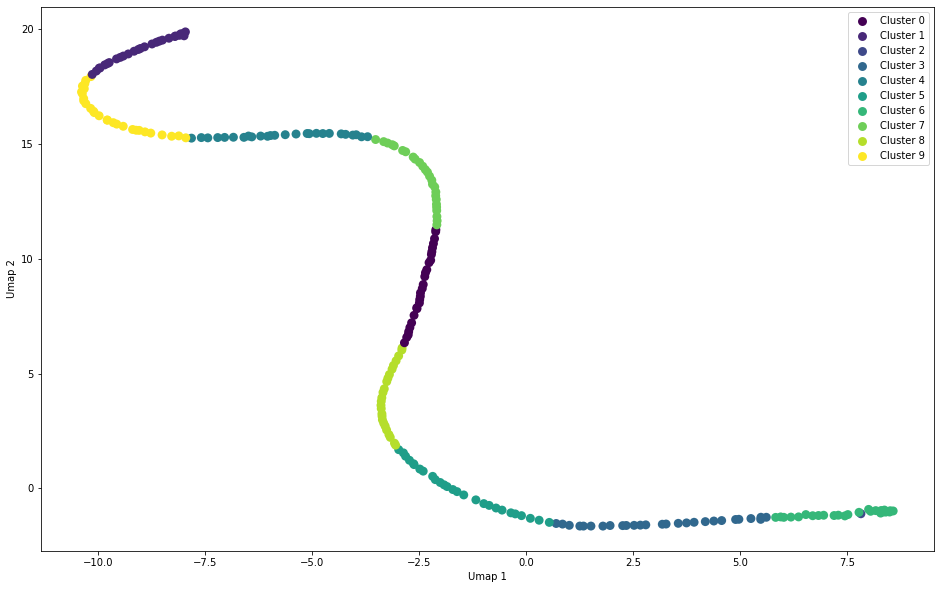

In [ ]:
# try basic clustering
kMeans_clustering()

Build Combined NeuMF

In [ ]:
graph = tf.Graph()

with graph.as_default():

    cell = tf.placeholder(tf.int32, shape=(None, 1))
    gene = tf.placeholder(tf.int32, shape=(None, 1))
    label = tf.placeholder(tf.int32, shape=(None, 1))


    mlp_c_var = tf.Variable(tf.random_normal([len(cells), 20], stddev=0.05),
            name='mlp_cell_embedding')
    mlp_cell_embedding = tf.nn.embedding_lookup(mlp_c_var, cell)


    mlp_g_var = tf.Variable(tf.random_normal([len(genes), 20], stddev=0.05),
            name='mlp_gene_embedding')
    mlp_gene_embedding = tf.nn.embedding_lookup(mlp_g_var, gene)


    gmf_c_var = tf.Variable(tf.random_normal([len(cells), latent_features],
        stddev=0.05), name='gmf_cell_embedding')
    gmf_cell_embedding = tf.nn.embedding_lookup(gmf_c_var, cell)

    # gene embedding for GMF
    gmf_g_var = tf.Variable(tf.random_normal([len(genes), latent_features],
        stddev=0.05), name='gmf_item_embedding')
    gmf_gene_embedding = tf.nn.embedding_lookup(gmf_g_var, gene)

    # flatten gmf embedding
    gmf_cell_embed = tf.keras.layers.Flatten()(gmf_cell_embedding)
    gmf_gene_embed = tf.keras.layers.Flatten()(gmf_gene_embedding)
    gmf_matrix = tf.multiply(gmf_cell_embed, gmf_gene_embed)

    # flatten mlp embedding
    mlp_cell_embed = tf.keras.layers.Flatten()(mlp_cell_embedding)
    mlp_gene_embed = tf.keras.layers.Flatten()(mlp_gene_embedding)
    mlp_concat = tf.keras.layers.concatenate([mlp_cell_embed, mlp_gene_embed])

    mlp_dropout = tf.keras.layers.Dropout(0.2)(mlp_concat)

    mlp_layer_1 = tf.keras.layers.Dense(64, activation='relu', name='layer1')(mlp_dropout)
    mlp_batch_norm1 = tf.keras.layers.BatchNormalization(name='batch_norm1')(mlp_layer_1)
    mlp_dropout1 = tf.keras.layers.Dropout(0.2, name='dropout1')(mlp_batch_norm1)

    mlp_layer_2 = tf.keras.layers.Dense(32, activation='relu', name='layer2')(mlp_dropout1)
    mlp_batch_norm2 = tf.keras.layers.BatchNormalization(name='batch_norm1')(mlp_layer_2)
    mlp_dropout2 = tf.keras.layers.Dropout(0.2, name='dropout1')(mlp_batch_norm2)

    mlp_layer_3 = tf.keras.layers.Dense(16, activation='relu', name='layer3')(mlp_dropout2)
    mlp_layer_4 = tf.keras.layers.Dense(8, activation='relu', name='layer4')(mlp_layer_3)

    # We merge the two networks together
    merged_vector = tf.keras.layers.concatenate([gmf_matrix, mlp_layer_4])

    # Our final single neuron output layer.
    output_layer = tf.keras.layers.Dense(1,
            kernel_initializer="lecun_uniform",
            name='output_layer')(merged_vector)

    # Our loss function as a binary cross entropy.
    loss = tf.losses.sigmoid_cross_entropy(label, output_layer)

    # Train using the Adam optimizer to minimize our loss.
    opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
    step = opt.minimize(loss)

    # Initialize all tensorflow variables.
    init = tf.global_variables_initializer()


session = tf.Session(config=None, graph=graph)
session.run(init)

In [ ]:
for epoch in range(epochs):

    # Get our training input.
    cell_input, gene_input, labels = get_train_instances()

    # Generate a list of minibatches.
    minibatches = random_mini_batches(cell_input, gene_input, labels)

    # This has noting to do with tensorflow but gives
    # us a nice progress bar for the training
    progress = tqdm(total=len(minibatches))

    # Loop over each batch and feed our cells, genes and labels
    # into our graph.
    for minibatch in minibatches:
        feed_dict = {cell: np.array(minibatch[0]).reshape(-1,1),
                    gene: np.array(minibatch[1]).reshape(-1,1),
                    label: np.array(minibatch[2]).reshape(-1,1)}

        # Execute the graph.
        _, l = session.run([step, loss], feed_dict)

        # Update the progress
        progress.update(1)
        progress.set_description('Epoch: %d - Loss: %.3f' % (epoch+1, l))

    progress.close()


# Calculate top@K
hits = evaluate(df_neg)
print(np.array(hits).mean())

Epoch: 20 - Loss: 0.000: 100%|██████████| 11950/11950 [00:43<00:00, 271.85it/s]


Streaming output truncated to the last 5000 lines.
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Genes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions:  [array([[-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557],
       [-32.52557]], dtype=float32)]
K Ranked:  [0]
Holdout:  0
Predict cell:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Genes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions:  [array([[-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632],
       [-32.13632]], dtype=float32)]
K Ranked:  [0]
Holdout:  0
Predict cell:  [[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]
Genes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions:  [array([[-31.685114],
       [-31.685114],
       [-31.685

In [ ]:
mlp_df = make_recommendation()
mlp_df.drop('Gene', axis=1, inplace=True)
mlp_df.head()

,Gene,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,-32.525570,-32.136318,-31.685114,-31.251369,-32.127563,-31.913084,-31.772465,-32.183903,-31.865746,-31.911633,-32.042122,-31.764294,-32.022366,-32.160217,-32.723507,-32.341263,-31.953140,-32.431942,-32.186676,-32.739704,-31.593998,-32.353794,-31.376926,-32.023495,-32.220383,-31.916208,-31.835495,-31.723286,-32.462234,-31.309919,-32.159107,-32.084930,-32.332016,-31.896477,-32.501877,-32.400372,-32.031948,-31.633375,-31.875603,...,-31.263920,-32.067326,-32.668747,-31.762611,-31.750803,-32.614277,-32.117462,-31.941784,-31.868059,-31.756750,-31.866486,-32.313538,-32.395344,-32.201370,-32.002041,-32.296436,-32.118462,-31.480206,-32.320126,-32.107590,-31.953964,-31.719582,-31.851313,-31.496534,-31.949703,-32.161560,-31.976786,-32.150146,-32.217735,-31.758480,-31.628149,-31.395657,-32.173706,-31.120152,-31.378132,-31.671637,-32.057125,-31.958773,-31.125896,-32.640469
1,1,23.384796,23.031010,21.734354,20.749855,22.278048,21.950287,22.713226,22.644505,22.152252,21.880184,22.062943,21.500904,21.907646,22.203747,23.317108,22.106272,21.699532,22.903288,21.924877,24.300476,21.111998,23.182571,21.331223,21.764050,22.909546,21.009499,21.572224,22.262297,23.362720,20.882065,21.866051,22.061039,23.613525,22.423431,23.844593,22.632780,22.095665,21.136051,21.702976,...,20.959694,22.133690,23.962528,21.492855,21.558289,22.623806,22.606756,22.644894,20.814880,22.555885,21.594242,22.084011,23.115444,22.573507,22.518600,22.905420,21.971138,21.085798,22.714733,22.544113,21.009230,21.176380,21.787853,21.714676,20.831663,23.040304,21.819199,22.647207,22.354084,22.368755,20.991615,20.763615,22.396448,20.842449,20.724777,21.202690,22.177624,22.821085,20.825483,23.234079
2,2,23.725895,23.530067,22.061592,21.091900,22.813013,22.359037,23.202908,22.947067,22.593365,22.262018,22.466042,21.881821,22.208103,22.538342,23.644535,22.334743,21.938038,23.208942,22.238705,24.708807,21.638325,23.477104,21.681511,22.103071,23.138329,21.401667,21.939804,22.602348,23.590424,21.320862,22.264217,22.452431,24.025015,22.810150,24.303984,23.067585,22.524670,21.522144,22.099327,...,21.269886,22.526472,24.280476,21.983849,22.042339,22.962067,22.969658,23.078342,21.150238,22.914486,21.964520,22.279610,23.371239,22.863705,22.904404,23.175762,22.309435,21.404116,23.045296,22.919523,21.442289,21.476213,22.245474,22.149300,21.132318,23.522949,22.331169,23.057663,22.628239,22.890762,21.267818,21.131283,22.935471,21.214542,21.297764,21.503716,22.721767,23.260897,21.191502,23.682735
3,3,22.504135,22.197617,20.923183,19.898914,21.458424,21.087402,21.947262,21.675793,21.285574,21.074524,21.159527,20.631386,20.950459,21.110584,22.364185,21.005932,20.639000,21.894823,20.980015,23.423241,20.331074,22.270103,20.491953,20.840313,21.854626,20.024132,20.655090,21.305067,22.281145,20.011284,20.877375,21.194450,22.694183,21.531528,23.035679,21.662714,21.187271,20.233067,20.748360,...,20.214348,21.158741,23.009007,20.582321,20.581228,21.510136,21.699989,21.812113,19.874662,21.828762,20.650776,21.006809,22.180920,21.612011,21.638332,21.880608,20.915813,20.189003,21.756699,21.735931,20.092312,20.148737,20.882877,20.975395,19.755005,22.284412,20.962524,21.680103,21.142292,21.702911,20.075165,19.936087,21.581650,20.057003,19.860561,20.300720,21.398741,22.022102,19.915142,22.277136
4,4,22.491192,22.064735,20.772461,19.698406,21.308533,20.955873,21.722775,21.543049,21.294235,20.941666,21.037930,20.543943,20.889313,21.170773,22.371466,21.050957,20.548065,21.852379,20.978012,23.318237,20.155510,22.174335,20.231991,20.795731,21.832245,20.108604,20.609322,21.233673,22.292614,19.899046,20.942654,21.078503,22.545866,21.477491,22.880472,21.667234,21.100163,20.095699,20.758945,...,19.988682,21.121321,22.910702,20.470182,20.550724,21.5

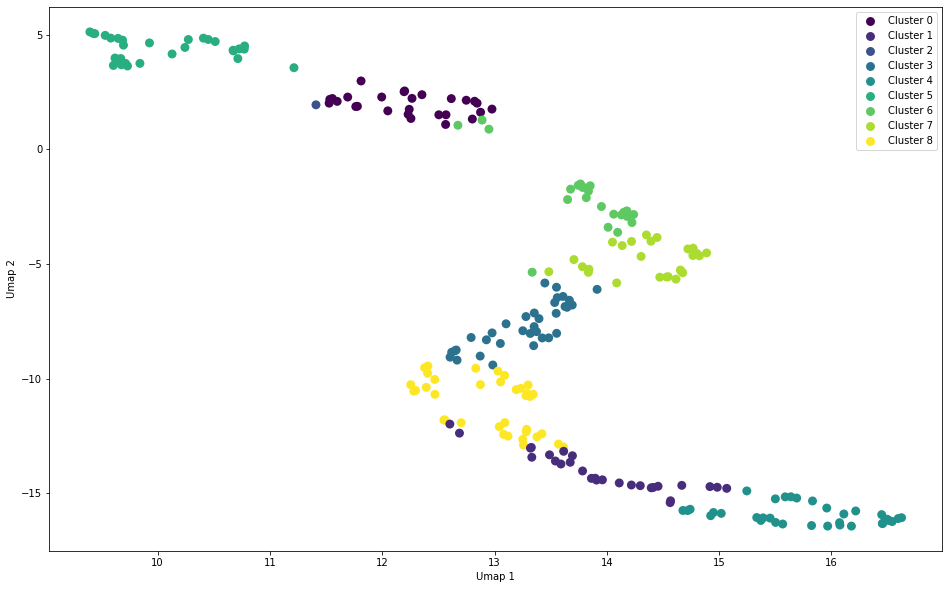

In [ ]:
# try basic clustering
kMeans_clustering(9)